Visualize the unit test galaxies and voids for VoidFinder.

This notebook is based off of the `VAST_dec_slices.ipynb` notebook by Dahlia Veyrat.

In [60]:
import numpy as np

import matplotlib
import matplotlib.pyplot as plt
from matplotlib.transforms import Affine2D
from matplotlib.projections import PolarAxes
import mpl_toolkits.axisartist.floating_axes as floating_axes
import mpl_toolkits.axisartist.angle_helper as angle_helper
from mpl_toolkits.axisartist.grid_finder import FixedLocator, MaxNLocator, DictFormatter

from astropy.table import Table, vstack
from astropy.io import fits
from astropy.cosmology import FlatLambdaCDM, z_at_value

from scipy.spatial import cKDTree, ConvexHull

from sympy import solve_poly_system, im
from sympy.abc import x,y

#from vast.voidfinder.distance import z_to_comoving_dist
from vast.voidfinder.constants import c
from vast.voidfinder import ra_dec_to_xyz, filter_galaxies

#matplotlib.rcParams.update({'font.size': 38})

# Data

## Galaxies

These are the galaxies generated by the unit test.

In [84]:
ra_range = np.arange(10, 30, 0.5)
dec_range = np.arange(-10, 10, 0.5)
redshift_range = np.arange(0, 0.011, 0.0005)

RA, DEC, REDSHIFT = np.meshgrid(ra_range, dec_range, redshift_range)

In [85]:
galaxies_table = Table()

galaxies_table['ra'] = np.ravel(RA)
galaxies_table['dec'] = np.ravel(DEC)
galaxies_table['redshift'] = np.ravel(REDSHIFT)

#galaxies_table['Rgal'] = c*galaxies_table['redshift']/100.

# All of the galaxies will be brighter than the magnitude limit, so that none of them are removed.
galaxies_table['rabsmag'] = 5*np.random.rand(len(galaxies_table)) - 25.1

### Separate galaxies into field and wall

In [86]:
w_galaxies_xyz, f_galaxies_xyz = filter_galaxies(galaxies_table, 
                                                 'test_', 
                                                 '', 
                                                 dist_metric='redshift',
                                                 write_table=False)

Filter Galaxies Start
Finding isolated galaxy distance
Time to find isolated galaxy distance: 0.1621401309967041
Removing all galaxies with 3rd nearest neighbors further than 0.2621916495445313
Number of field gals: 1624 Number of wall gals: 33576


## Voids

### Inputted voids

In [64]:
maximals = Table()

maximals['x'] = [25., 10.]
maximals['y'] = [8., 3.]
maximals['z'] = [0., -1.]

maximals['radius'] = [2.5, 1.5]

maximals['flag'] = [0, 1]

maximals['edge'] = [0, 0]

In [65]:
holes = Table()

holes['x'] = [24., 10.5]
holes['y'] = [7.9, 3.2]
holes['z'] = [0.1, -0.5]

holes['radius'] = [2., 0.5]

holes['flag'] = [0, 1]

holes = vstack([holes, maximals])

#### Sort voids

In [66]:
holes_x_true = []
holes_y_true = []
holes_z_true = []
holes_r_true = []

for vfl in np.unique(holes['flag']):
    
    holes_in_void = holes['flag'] == vfl
    
    holes_x_true.append(holes['x'][holes_in_void])
    holes_y_true.append(holes['y'][holes_in_void])
    holes_z_true.append(holes['z'][holes_in_void])
    holes_r_true.append(holes['radius'][holes_in_void])

### "Old" truth voids

In [102]:
maximals_old = Table.read(#'/Users/kellydouglass/Documents/Research/Voids/VAST/python/vast/voidfinder/tests/test_galaxies_redshift_maximal_truth.txt', 
                          '/Users/kellydouglass/Desktop/Voids_old/VAST/VoidFinder/vast/voidfinder/tests/test_galaxies_redshift_maximal.txt', 
                          format='ascii.commented_header')

holes_old = Table.read(#'/Users/kellydouglass/Documents/Research/Voids/VAST/python/vast/voidfinder/tests/test_galaxies_redshift_holes_truth.txt', 
                       '/Users/kellydouglass/Desktop/Voids_old/VAST/VoidFinder/vast/voidfinder/tests/test_galaxies_redshift_holes.txt', 
                       format='ascii.commented_header')

#### Sort voids

In [103]:
holes_x_old = []
holes_y_old = []
holes_z_old = []
holes_r_old = []

for vfl in np.unique(holes_old['flag']):
    
    holes_in_void = holes_old['flag'] == vfl
    
    holes_x_old.append(holes_old['x'][holes_in_void])
    holes_y_old.append(holes_old['y'][holes_in_void])
    holes_z_old.append(holes_old['z'][holes_in_void])
    holes_r_old.append(holes_old['radius'][holes_in_void])

### "New" truth voids

In [119]:
maximals_new = Table.read('/Users/kellydouglass/Documents/Research/Voids/VAST/test_galaxies_redshift_maximal.txt', 
                          format='ascii.commented_header')

holes_new = Table.read('/Users/kellydouglass/Documents/Research/Voids/VAST/test_galaxies_redshift_holes.txt', 
                       format='ascii.commented_header')

#### Sort voids

In [120]:
holes_x_new = []
holes_y_new = []
holes_z_new = []
holes_r_new = []

for vfl in np.unique(holes_new['flag']):
    
    holes_in_void = holes_new['flag'] == vfl
    
    holes_x_new.append(holes_new['x'][holes_in_void])
    holes_y_new.append(holes_new['y'][holes_in_void])
    holes_z_new.append(holes_new['z'][holes_in_void])
    holes_r_new.append(holes_new['radius'][holes_in_void])

# Remove wall galaxies that fall inside the original spheres

In [104]:
remove_boolean = np.zeros(len(w_galaxies_xyz), dtype=bool)

for i in range(len(holes)):
    
    d = (holes['x'][i] - w_galaxies_xyz[:,0])**2 + (holes['y'][i] - w_galaxies_xyz[:,1])**2 + (holes['z'][i] - w_galaxies_xyz[:,2])**2
    
    remove_boolean = remove_boolean | (d < holes['radius'][i]**2)
    
wall_galaxies_xyz = w_galaxies_xyz[~remove_boolean]
field_galaxies_xyz = np.concatenate([f_galaxies_xyz, w_galaxies_xyz[remove_boolean]])

# Void intersection functions

In [72]:
def cint(z, z_void, radius_void):
    '''
    Calculate radii of maximal sphere-slice intersections
    
    
    PARAMETERS
    ==========
    
    z : float
        z-coordinate of slice
        
    z_void : ndarray of shape (n,)
        z-coordinates of void centers
        
    radius_void : ndarray of shape (n,)
        radii of maximal spheres
        
        
    RETURNS
    =======
    
    cr : ndarray of shape (n,)
        radii of intersection of maximal spheres with slice
    '''
    
    # Initialize output array
    cr = np.zeros(len(radius_void))
    
    for i in range(len(z_void)):
        
        dtd = np.abs(z_void[i] - z)
        
        if dtd <= radius_void[i]:
            # Maximal sphere interescts slice
            cr[i] = np.sqrt(radius_void[i]**2. - dtd**2.)
            
    return cr




def cint2(z, z_holes, radius_holes):
    '''
    Calculate radii of hole-slice intersections
    
    
    PARAMETERS
    ==========
    
    z : float
        z-coordinate of slice
        
    z_holes : list of lists
        z-coordinates of hole centers
        
    radius_holes : list of lists
        radii of holes
        
        
    RETURNS
    =======
    
    cr : list of lists
        radii of intersection of maximal spheres with slice
    '''
    
    # Initialize output list
    cr = []
    
    for i in range(len(z_holes)):
        
        cr.append([])
        
        for j in range(len(z_holes[i])):
            
            dtd = np.abs(z_holes[i][j] - z)
            
            if dtd > radius_holes[i][j]:
                cr[i].append(0.)
            else:
                cr[i].append(np.sqrt(radius_holes[i][j]**2. - dtd**2.))
    
    return cr




def isin(p,ps,ch,chavg,chrad):
    if np.sum((p-chavg)**2.)<chrad:
        return True
    nc = 1
    
    for smp in ch.simplices:
        ps2 = ps[smp]
        if ps2[0][0]<p[0]:
            continue
        elif ps2[1][0]<p[0]:
            continue
        elif (ps2[0][1]-p[1])*(ps2[1][1]-p[1])<0:
            nc = nc+1
        elif (ps2[0][1]-p[1])*(ps2[1][1]-p[1])==0:
            nc = nc+0.5
    return nc%2==0




def isin2(p,ps):
    nc = 1
    for i in range(len(ps)-1):
        if p1[0]<p[0] and p2[0]<p[0]:
            continue
        elif (p1[1]-p[1])*(p2[1]-p[1])>0:
            continue
        elif p1[0]>p[0] and p2[0]>p[0]:
            nc = nc+1
        elif ((p2[1]-p1[1])/(p2[0]-p1[0]))*((p1[1]-p[1])-((p2[1]-p1[1])/(p2[0]-p1[0]))*(p1[0]-p[0]))<1:
            nc = nc+1
    return nc%2==0





def trint(dec):
    '''
    Calculate coordinates of triangle-slice intersections
    '''
    decsum = np.array([(p1_dec>dec).astype(int),(p2_dec>dec).astype(int),(p3_dec>dec).astype(int)]).T
    intr  = [[] for _ in range(np.amax(trivids)+1)]
    intra = [[] for _ in range(np.amax(trivids)+1)]
    for i in range(len(trivids)):
        if np.sum(decsum[i])==0:
            continue
        if np.sum(decsum[i])==3:
            continue
        cv = trivids[i]
        if np.sum(decsum[i])==1:
            if decsum[i][0]==1:
                intr[cv].append((p1_r[i]+p2_r[i])/2.)
                intr[cv].append((p1_r[i]+p3_r[i])/2.)
                intra[cv].append((p1_ra[i]+p2_ra[i])/2.)
                intra[cv].append((p1_ra[i]+p3_ra[i])/2.)
            elif decsum[i][1]==1:
                intr[cv].append((p2_r[i]+p1_r[i])/2.)
                intr[cv].append((p2_r[i]+p3_r[i])/2.)
                intra[cv].append((p2_ra[i]+p1_ra[i])/2.)
                intra[cv].append((p2_ra[i]+p3_ra[i])/2.)
            elif decsum[i][2]==1:
                intr[cv].append((p3_r[i]+p1_r[i])/2.)
                intr[cv].append((p3_r[i]+p2_r[i])/2.)
                intra[cv].append((p3_ra[i]+p1_ra[i])/2.)
                intra[cv].append((p3_ra[i]+p2_ra[i])/2.)
        elif np.sum(decsum[i])==2:
            if decsum[i][0]==0:
                intr[cv].append((p1_r[i]+p2_r[i])/2.)
                intr[cv].append((p1_r[i]+p3_r[i])/2.)
                intra[cv].append((p1_ra[i]+p2_ra[i])/2.)
                intra[cv].append((p1_ra[i]+p3_ra[i])/2.)
            elif decsum[i][1]==0:
                intr[cv].append((p2_r[i]+p1_r[i])/2.)
                intr[cv].append((p2_r[i]+p3_r[i])/2.)
                intra[cv].append((p2_ra[i]+p1_ra[i])/2.)
                intra[cv].append((p2_ra[i]+p3_ra[i])/2.)
            elif decsum[i][2]==0:
                intr[cv].append((p3_r[i]+p1_r[i])/2.)
                intr[cv].append((p3_r[i]+p2_r[i])/2.)
                intra[cv].append((p3_ra[i]+p1_ra[i])/2.)
                intra[cv].append((p3_ra[i]+p2_ra[i])/2.)
    return intr,intra




def getinx(xx,aa,yy,bb,zz,cc,dd):
    negb = -1.*aa*xx-bb*yy+cc*dd*dd*zz
    sqto = 0.5*np.sqrt((2.*aa*xx+2.*bb*yy-2.*cc*dd*dd*zz)**2.-4.*(aa**2.+bb**2.-cc*cc*dd*dd)*(xx**2.+yy**2.-zz*zz*dd*dd))
    twa = aa**2.+bb**2.-cc*cc*dd*dd
    tt = (negb+sqto)/twa
    if tt>0 and tt<1:
        tt = tt
    else:
        tt = (negb-sqto)/twa
    return xx+aa*tt,yy+bb*tt,zz+cc*tt




def trint2(dec):
    decsum = np.array([(p1_dec>dec).astype(int),(p2_dec>dec).astype(int),(p3_dec>dec).astype(int)]).T
    intr  = [[] for _ in range(np.amax(trivids)+1)]
    intra = [[] for _ in range(np.amax(trivids)+1)]
    for i in range(len(trivids)):
        if np.sum(decsum[i])==0:
            continue
        if np.sum(decsum[i])==3:
            continue
        cv = trivids[i]
        if np.sum(decsum[i])==1:
            if decsum[i][0]==1:
                sss = getinx(p1_x[i],p2_x[i]-p1_x[i],p1_y[i],p2_y[i]-p1_y[i],p1_z[i],p2_z[i]-p1_z[i],1./np.tan(dec*D2R))
                sst = getinx(p1_x[i],p3_x[i]-p1_x[i],p1_y[i],p3_y[i]-p1_y[i],p1_z[i],p3_z[i]-p1_z[i],1./np.tan(dec*D2R))
            elif decsum[i][1]==1:
                sss = getinx(p1_x[i],p2_x[i]-p1_x[i],p1_y[i],p2_y[i]-p1_y[i],p1_z[i],p2_z[i]-p1_z[i],1./np.tan(dec*D2R))
                sst = getinx(p3_x[i],p2_x[i]-p3_x[i],p3_y[i],p2_y[i]-p3_y[i],p3_z[i],p2_z[i]-p3_z[i],1./np.tan(dec*D2R))
            elif decsum[i][2]==1:
                sss = getinx(p1_x[i],p3_x[i]-p1_x[i],p1_y[i],p3_y[i]-p1_y[i],p1_z[i],p3_z[i]-p1_z[i],1./np.tan(dec*D2R))
                sst = getinx(p3_x[i],p2_x[i]-p3_x[i],p3_y[i],p2_y[i]-p3_y[i],p3_z[i],p2_z[i]-p3_z[i],1./np.tan(dec*D2R))
        elif np.sum(decsum[i])==2:
            if decsum[i][0]==0:
                sss = getinx(p1_x[i],p2_x[i]-p1_x[i],p1_y[i],p2_y[i]-p1_y[i],p1_z[i],p2_z[i]-p1_z[i],1./np.tan(dec*D2R))
                sst = getinx(p1_x[i],p3_x[i]-p1_x[i],p1_y[i],p3_y[i]-p1_y[i],p1_z[i],p3_z[i]-p1_z[i],1./np.tan(dec*D2R))
            elif decsum[i][1]==0:
                sss = getinx(p1_x[i],p2_x[i]-p1_x[i],p1_y[i],p2_y[i]-p1_y[i],p1_z[i],p2_z[i]-p1_z[i],1./np.tan(dec*D2R))
                sst = getinx(p3_x[i],p2_x[i]-p3_x[i],p3_y[i],p2_y[i]-p3_y[i],p3_z[i],p2_z[i]-p3_z[i],1./np.tan(dec*D2R))
            elif decsum[i][2]==0:
                sss = getinx(p1_x[i],p3_x[i]-p1_x[i],p1_y[i],p3_y[i]-p1_y[i],p1_z[i],p3_z[i]-p1_z[i],1./np.tan(dec*D2R))
                sst = getinx(p3_x[i],p2_x[i]-p3_x[i],p3_y[i],p2_y[i]-p3_y[i],p3_z[i],p2_z[i]-p3_z[i],1./np.tan(dec*D2R))
        intr[cv].append(np.sqrt(np.sum(np.array(sss)**2.)))
        intr[cv].append(np.sqrt(np.sum(np.array(sst)**2.)))
        intra[cv].append((np.arccos(sss[0]/np.sqrt(sss[0]**2.+sss[1]**2.))*np.sign(sss[1])/D2R)%360)
        intra[cv].append((np.arccos(sst[0]/np.sqrt(sst[0]**2.+sst[1]**2.))*np.sign(sst[1])/D2R)%360)
    return intr,intra

# Void boundary plotting functions

In [73]:
def gcp(x, y, r, npt):
    '''
    Convert a circle's coordinates to ordered boundary
    
    
    PARAMETERS
    ==========
    
    x, y : float
        x- and y-coordinates of circle's center
        
    r : float
        radius of circle
        
    npt : float
        number of points to distribute around circle
        
        
    RETURNS
    =======
    
    Cx, Cy : ndarray of shape (npt,)
        x- and y-coordinates of points around circle boundary
    '''
    
    Cx = np.linspace(0., 2*np.pi, npt)
    Cy = np.linspace(0., 2*np.pi, npt)
    
    Cx = np.cos(Cx)*r + x
    Cy = np.sin(Cy)*r + y
    
    #C1 = np.sqrt(Cx**2. + Cy**2.)
    #C2 = (np.sign(Cy)*np.arccos(Cx/C1) + np.pi*(1. - np.sign(Cy)))/D2R
    
    #return C1, C2
    return Cx, Cy

# Void plotting functions

In [74]:
def plot_maximals(z, wdth, npc, voids, labels, wall_gal, field_gal):
    '''
    Plot VoidFinder maximal spheres
    
    
    PARAMETERS
    ==========
    
    z : float
        z-coordinate of slice
        
    wdth : float
        Thickness of slice (in Mpc/h)
    
    npc : float
        Number of points to distribute along the boundary of the void
    
    voids : list of astropy tables
        Tables containing maximal sphere center coordinates and radii
        
    labels : list of strings
        Legend labels for the voids
    
    galaxy_coords : ndarray of shape (n,3)
        galaxy Cartesian coordinates
    '''
    
    plt.figure(1, figsize=(11,6))
    #fig = plt.figure(1, figsize=(1600/96,800/96))
    
    #ax3, aux_ax3 = setup_axes3(fig, 111)
    
    # Void color
    colors = 'bgm'
    
    for j in range(len(voids)):
        
        # Calculate intersection radii of maximal spheres
        Cr = cint(z, voids[j]['z'], voids[j]['radius'])
        
        for i in range(len(voids[j])):
        
            if Cr[i] > 0:

                # Create boundary of maximal sphere
                Cx, Cy = gcp(voids[j]['x'][i], voids[j]['y'][i], Cr[i], npc)

                if i == 0:
                    plt.plot(Cx, Cy, color=colors[j], label=labels[j])
                else:
                    plt.plot(Cx, Cy, color=colors[j])
                
                plt.fill(Cx, Cy, color=colors[j], alpha=0.2)
    
    # Plot wall galaxies
    galaxies_in_slice = np.abs(wall_gal[:,2] - z) < wdth
    plt.scatter(wall_gal[:,0][galaxies_in_slice], 
                wall_gal[:,1][galaxies_in_slice], 
                color='k', 
                s=1)
    
    # Plot field galaxies
    galaxies_in_slice = np.abs(field_gal[:,2] - z) < wdth
    plt.scatter(field_gal[:,0][galaxies_in_slice], 
                field_gal[:,1][galaxies_in_slice], 
                color='r', 
                s=1)
    
    plt.legend()
    
    plt.show()

    
    

def pvf2(dec,wdth,npc,chkdpth):
    '''
    Plot VoidFinder voids
    '''
    fig = plt.figure(1, figsize=(1600/96,800/96))
    
    ax3, aux_ax3 = setup_axes3(fig, 111)
    
    Cr = cint2(dec)
    
    for i in range(len(vfr)):
        
        if np.sum(Cr[i])>0:
            
            Cr2, Cra2 = gcp2(vfr2[i], vfra2[i], Cr[i], npc, chkdpth)
            
            if vfedge[i]:
                vcolor = 'purple'
            else:
                vcolor = 'blue'
            
            #vcolor = 'blue'
            
            aux_ax3.plot(Cra2, Cr2, color=vcolor)
            aux_ax3.fill(Cra2, Cr2, color=vcolor, alpha=0.2)
            
        #Cr2,Cra2 = gcp3(vfx4[i],vfy4[i],vfz4[i],vfr2[i],vfrad2[i],vfdec2[i],dec,npc,chkdpth)
        #if len(Cr2)>0:
        #    aux_ax3.plot(Cra2,Cr2,color='blue')
        #    aux_ax3.fill(Cra2,Cr2,alpha=0.5,color='blue')
        
    # Edge galaxies
    gdcut = (gr[eflag_vf]*np.sin((gdec[eflag_vf] - dec)*D2R))**2 < wdth**2
    aux_ax3.scatter(gra[eflag_vf][gdcut], gr[eflag_vf][gdcut], color='g', s=1, alpha=0.5)
    
    # Wall galaxies
    gdcut = (gr[wflag_vf]*np.sin((gdec[wflag_vf] - dec)*D2R))**2. < wdth**2.
    aux_ax3.scatter(gra[wflag_vf][gdcut], gr[wflag_vf][gdcut], color='k', s=1)
    
    # Void galaxies
    gdcut = (gr[gflag_vf]*np.sin((gdec[gflag_vf] - dec)*D2R))**2. < wdth**2.
    aux_ax3.scatter(gra[gflag_vf][gdcut], gr[gflag_vf][gdcut], color='r', s=1)
    
    plt.show()

# Plots!

## Maximals only

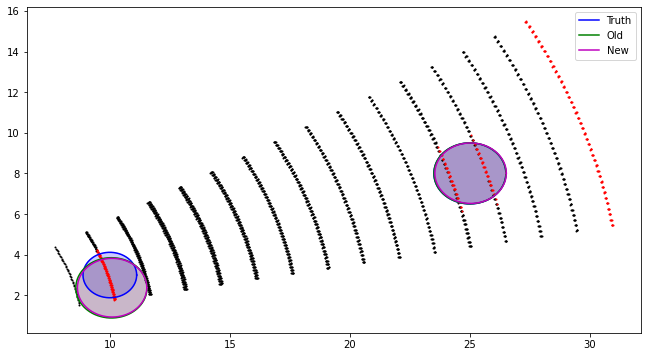

In [121]:
plot_maximals(-2, 0.5, 1000, 
              [maximals, maximals_old, maximals_new], ['Truth', 'Old', 'New'], 
              wall_galaxies_xyz, field_galaxies_xyz)